# Simulations in Garfield++ with open source finite element calculations

# Set up the environment

Get pre-compiled binaries

In [ ]:
!wget https://www.dropbox.com/s/7jmeaiy73dlf3ru/environ.tar.gz
!tar -xvf environ.tar.gz

Streaming output truncated to the last 5000 lines.
root/install/include/ZipZSTD.h
root/install/include/BatchHelpers.h
root/install/include/TFractionFitter.h
root/install/include/RooStepFunction.h
root/install/include/TGText.h
root/install/include/RooUniformBinning.h
root/install/include/TPolyMarker3D.h
root/install/include/TRandomGen.h
root/install/include/TGeoPolygon.h
root/install/include/TGenPhaseSpace.h
root/install/include/TGLSphere.h
root/install/include/TH2Poly.h
root/install/include/RooBinningCategory.h
root/install/include/TLine.h
root/install/include/TImage.h
root/install/include/TGLManip.h
root/install/include/TLeafB.h
root/install/include/TGraphErrors.h
root/install/include/FTGLPixmapFont.h
root/install/include/RooAbsCategoryLValue.h
root/install/include/RooNumGenFactory.h
root/install/include/TGridResult.h
root/install/include/TMapFile.h
root/install/include/RooSetProxy.h
root/install/include/TPolyLine.h
root/install/include/TStyleDialog.h
root/install/include/TGeoParallel

Set environment variables and load the necessary libraries

In [ ]:
import numpy as np

# Set the environment variables.
import os
os.environ["GARFIELD_HOME"] = "/content/garfield/garfieldpp"
os.environ["ROOTSYS"] = "/content/root/install"
os.environ["PATH"] += ":/content/elmer/install/bin:/content/gmsh/bin"

# Load the ROOT and Garfield libraries.
import sys
sys.path.append("/content/root/install/lib")

import ctypes
ctypes.cdll.LoadLibrary('/content/root/install/lib/libCore.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libThread.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libImt.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libRIO.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libNet.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libTree.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libMathCore.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libMatrix.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libHist.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libGeom.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libXMLIO.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libGdml.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libGraf.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libGpad.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libGraf3d.so')

import ROOT
ROOT.gSystem.Load("/content/garfield/install/lib/libGarfield.so")
%jsroot off

# Change the working directory.
working_dir = "/content/examples"
os.mkdir(working_dir)
os.chdir(working_dir)

# 2D wire example

## Create the FEM map

#### Create the geometry file

In [ ]:
wire2d_geo_text = """
// Create a 2D wire geometry
s = 10;  // side length of enclosing region
r = 1;   // radius of wire

lcBoundary = 0.4;  // characteristic length near enclosing region
lcWire = 0.4;      // characteristic length near wire

// Create the bounding box.
pbox0 = newp; Point(pbox0) = {-s/2, s/2,  0, lcBoundary};
pbox1 = newp; Point(pbox1) = {s/2,  s/2,  0, lcBoundary};
pbox2 = newp; Point(pbox2) = {s/2,  -s/2, 0, lcBoundary};
pbox3 = newp; Point(pbox3) = {-s/2, -s/2, 0, lcBoundary};
lbox0 = newc; Line(lbox0)  = {pbox0, pbox1};
lbox1 = newc; Line(lbox1)  = {pbox1, pbox2};
lbox2 = newc; Line(lbox2)  = {pbox2, pbox3};
lbox3 = newc; Line(lbox3)  = {pbox3, pbox0};
llbox = newreg; Line Loop(llbox) = {lbox0, lbox1, lbox2, lbox3};

// Create the wire.
pcenter = newp; Point(pcenter) = {0,  0,  0, lcWire};
pwire0 = newp; Point(pwire0) = {r,  0,  0, lcWire};
pwire1 = newp; Point(pwire1) = {0,  -r, 0, lcWire};
pwire2 = newp; Point(pwire2) = {-r, 0,  0, lcWire};
pwire3 = newp; Point(pwire3) = {0,  r,  0, lcWire};
cwire0 = newc; Circle(cwire0) = {pwire0, pcenter, pwire1};
cwire1 = newc; Circle(cwire1) = {pwire1, pcenter, pwire2};
cwire2 = newc; Circle(cwire2) = {pwire2, pcenter, pwire3};
cwire3 = newc; Circle(cwire3) = {pwire3, pcenter, pwire0};
llwire = newreg; Line Loop(llwire) = {cwire0, cwire1, cwire2, cwire3};

// Create the surfaces.
physcbox = newreg; Physical Curve(physcbox) = {lbox0, lbox1, lbox2, lbox3};
psbox  = newreg; Plane Surface(psbox) = {llbox, llwire};
physsbox = newreg; Physical Surface(physsbox) = {psbox};

physcwire = newreg; Physical Curve(physcwire) = {cwire0, cwire1, cwire2, cwire3};
pswire = newreg; Plane Surface(pswire) = {llwire};
physswire = newreg; Physical Surface(physswire) = {pswire};

//Mesh.Algorithm = 8;
Mesh.RecombinationAlgorithm = 2;
Mesh.ElementOrder = 2;
Mesh.SecondOrderIncomplete = 1;
Mesh.SubdivisionAlgorithm = 1;

Mesh 2;
RecombineMesh;
RefineMesh;
"""

wire2d_geo_file = open("wire2d.geo", "w")
wire2d_geo_file.write(wire2d_geo_text)
wire2d_geo_file.close()

#### Create the mesh with Gmsh

In [ ]:
!gmsh wire2d.geo -2 -order 2

Info    : Running 'gmsh wire2d.geo -2 -order 2' [Gmsh 4.5.6, 1 node, max. 1 thread]
Info    : Started on Tue Jun 16 17:35:55 2020
Info    : Reading 'wire2d.geo'...
Info    : Meshing 1D...
Info    : [  0 %] Meshing curve 1 (Line)
Info    : [ 20 %] Meshing curve 2 (Line)
Info    : [ 30 %] Meshing curve 3 (Line)
Info    : [ 40 %] Meshing curve 4 (Line)
Info    : [ 50 %] Meshing curve 6 (Circle)
Info    : [ 70 %] Meshing curve 7 (Circle)
Info    : [ 80 %] Meshing curve 8 (Circle)
Info    : [ 90 %] Meshing curve 9 (Circle)
Info    : Done meshing 1D (0.001249 s)
Info    : Meshing 2D...
Info    : [  0 %] Meshing surface 12 (Plane, Frontal-Delaunay)
Info    : [ 50 %] Meshing surface 15 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (0.042439 s)
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0 %] Meshing curve 1 order 2
Info    : [ 10 %] Meshing curve 2 order 2
Info    : [ 20 %] Meshing curve 3 order 2
Info    : [ 30 %] Meshing curve 4 order 2
Info   

#### Convert the mesh to Elmer format

In [ ]:
!ElmerGrid 14 2 wire2d.msh -autoclean


Starting program Elmergrid
Elmergrid reading in-line arguments
Lower dimensional boundaries will be removed
Materials and boundaries will be renumbered
Nodes that do not appear in any element will be removed
Output will be saved to file wire2d.

Elmergrid loading data:
-----------------------
Format chosen using the first line: $MeshFormat
Gmsh version is 4.1
Loading mesh in Gmsh format 4.1 from file wire2d.msh
Reading 9 entities in 0D
Reading 8 entities in 1D
Reading 2 entities in 2D
Allocating for 212913 knots and 71632 elements.
Allocating lookup table for tags of size 15
Maximum original tag for 8 1DIM entities is 9
Maximum original tag for 2 2DIM entities is 15
Reading 212913 nodes in 18 blocks.
Reading 71632 elements in 10 blocks.
Reading 200 elements with tag 1 of type 203
Mapping mesh tag 1 to physical tag 11 in 1DIM
Reading 200 elements with tag 2 of type 203
Mapping mesh tag 2 to physical tag 11 in 1DIM
Reading 200 elements with tag 3 of type 203
Mapping mesh tag 3 to physic

#### Create the .sif file

In [ ]:
wire2d_sif_text = """
Check Keywords Warn

$Vwire = 1000

Header
  Mesh DB "." "wire2d"
End

Simulation
  Coordinate System = "Cartesian 2D"
  Coordinate Mapping(3) = 1 2 3
  Simulation Type = Steady state
  Steady State Max Iterations = 1
  Output Intervals = 1
  Output File = "wire2d.result"
  Post File = "wire2d.ep"
End

Constants
  Permittivity of Vacuum = 8.8542e-12
  Unit Charge = 1.602e-19
End

Body 1
  Equation = 1
  Material = 1
End

Body 2
  Equation = 1
  Material = 2
End

Solver 1
  Equation = Electrostatics
  Calculate Electric Energy = True
  Calculate Electric Field = True
  Calculate Electric Flux = False
  Variable = Potential
  Procedure = "StatElecSolve" "StatElecSolver"
  Linear System Solver = Iterative
  Linear System Iterative Method = BiCGStab
  Linear System Max Iterations = 1000
  Linear System Abort Not Converged = True
  Linear System Convergence Tolerance = 1.0e-10
  Linear System Preconditioning = ILU1
  Steady State Convergence Tolerance = 5.0e-7
End

Equation 1
  Active Solvers(1) = 1
End

Material 1
  Relative Permittivity = 1
End

Material 2
  Relative Permittivity = 1e10
End

! Outer boundaries
Boundary Condition 1
  Target Boundaries(1) = 1
  Potential = 0
End

! Wire
Boundary Condition 2
  Target Boundaries(1) = 2
  Potential = $Vwire
End
"""

wire2d_sif_file = open("wire2d.sif", "w")
wire2d_sif_file.write(wire2d_sif_text)
wire2d_sif_file.close()

#### Solve for the fields with ElmerSolver

In [ ]:
!ElmerSolver wire2d.sif

ELMER SOLVER (v 8.4) STARTED AT: 2020/06/16 17:36:15
ParCommInit:  Initialize #PEs:            1
MAIN: 
MAIN: =============================================================
MAIN: ElmerSolver finite element software, Welcome!
MAIN: This program is free software licensed under (L)GPL
MAIN: Copyright 1st April 1995 - , CSC - IT Center for Science Ltd.
MAIN: Webpage http://www.csc.fi/elmer, Email elmeradm@csc.fi
MAIN: Version: 8.4 (Rev: 6cc1ffbd, Compiled: 2020-06-15)
MAIN:  Running one task without MPI parallelization.
MAIN:  Running with just one thread per task.
MAIN: =============================================================
LoadInputFile: Reading only "Run Control" section
MAIN: 
MAIN: 
MAIN: -------------------------------------
MAIN: Reading Model: wire2d.sif
LoadInputFile: Scanning input file: wire2d.sif
LoadInputFile: Scanning only size info
LoadInputFile: First time visiting
LoadInputFile: Reading base load of sif file
LoadInputFile: Loading input file: wire2d.sif
LoadInputFile

#### Create a file `dielectrics.dat`

In [ ]:
wire2d_dielectrics_text = """2
1 1.0
2 1.0e10
"""
wire2d_dielectrics_file = open("wire2d/dielectrics.dat", "w")
wire2d_dielectrics_file.write(wire2d_dielectrics_text)
wire2d_dielectrics_file.close()

## Import the field map into Garfield++

### Setup

In [ ]:
# Set up the gas medium.
gas = ROOT.Garfield.MediumMagboltz()
gas.SetTemperature(293.15)
gas.SetPressure(740.)
gas.SetComposition("ar", 70., "co2", 30.)
gas.EnableDrift()

MediumMagboltz::SetComposition:
    Ar/CO2 (70/30)


In [ ]:
# Read in the 2D field map.
elm = ROOT.Garfield.ComponentElmer2D("wire2d/mesh.header", "wire2d/mesh.elements", "wire2d/mesh.nodes", 
                                     "wire2d/dielectrics.dat", "wire2d/wire2d.result", "cm")
elm.SetMedium(0, gas)

ComponentElmer2D::Initialise:
    Read 212913 nodes and 70704 elements from file wire2d/mesh.header.
ComponentElmer2D::Initialise:
    Set material 0 of 2 to eps 1.
ComponentElmer2D::Initialise:
    Set material 1 of 2 to eps 1e+10.
ComponentElmer2D::Initialise: Finished.


In [ ]:
# Create a Sensor object.
axis_x = axis_y = axis_z = 5
sensor = ROOT.Garfield.Sensor();
sensor.AddComponent(elm);
sensor.SetArea(-axis_x, -axis_y, -axis_z, axis_x, axis_y, axis_z);

### Launch a single avalanche, keeping track of the drift line

In [ ]:
# Create the avalanche object.
aval = ROOT.Garfield.AvalancheMicroscopic()
aval.SetSensor(sensor)
aval.SetCollisionSteps(10)

# Set up a viewer for the drift lines.
viewDrift = ROOT.Garfield.ViewDrift()
viewDrift.SetArea(-axis_x, -axis_y, -axis_z, axis_x, axis_y, axis_z);
aval.EnablePlotting(viewDrift);

AvalancheMicroscopic::EnablePlotting:
    Enabling storage of drift line.


In [ ]:
# Set up and launch the avalanche.
ri = 4.0
thetai = np.random.uniform() * 2 * np.pi
xi = ri * np.cos(thetai)
yi = ri * np.sin(thetai)
zi = 0
aval.AvalancheElectron(xi, yi, zi, 0., 0., 0., 0., 0.)

True

### Plot the results

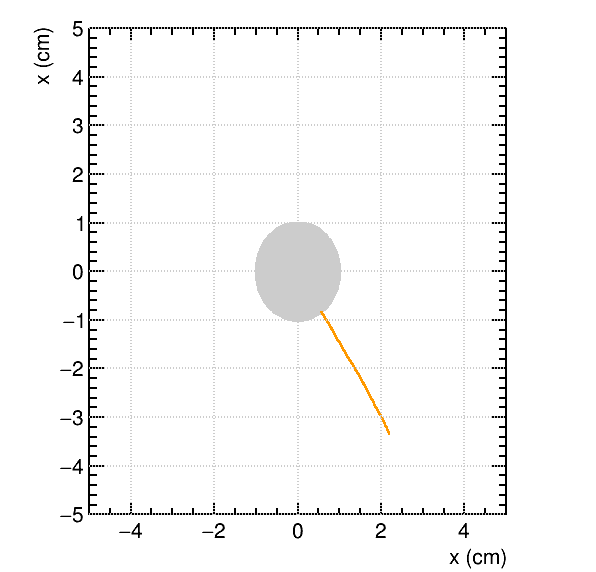

In [ ]:
cGeom = ROOT.TCanvas("geom", "Geometry")
viewMesh = ROOT.Garfield.ViewFEMesh()
viewMesh.SetArea(-axis_x, -axis_z, -axis_y, axis_x, axis_z, axis_y)
viewMesh.SetCanvas(cGeom)
viewMesh.SetComponent(elm)
viewMesh.SetPlane(0, 0, 1, 0, 0, 0)
viewMesh.SetFillMesh(False)
viewMesh.SetColor(1,ROOT.kGray)
viewMesh.EnableAxes()
viewMesh.SetXaxisTitle("x (cm)")
viewMesh.SetYaxisTitle("x (cm)")
viewMesh.SetViewDrift(viewDrift)
viewMesh.Plot()
cGeom.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: fields


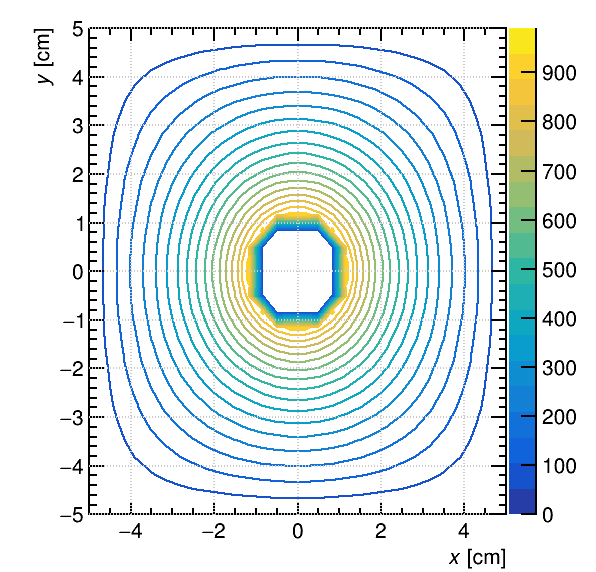

In [ ]:
cFields = ROOT.TCanvas("fields", "Fields")
viewField = ROOT.Garfield.ViewField()
viewField.SetSensor(sensor)
viewField.SetCanvas(cFields)
viewField.SetArea(-axis_x, -axis_y, axis_x, axis_y)
viewField.SetNumberOfContours(20)
viewField.SetNumberOfSamples2d(30, 30)
viewField.SetPlane(0, 0, 1, 0, 0, 0)
viewField.PlotContour("v")
cFields.Draw()

## 3D LEM example

### Create the FEM map

#### Create the geometry file

### Import the field map into Garfield++

## Create a parallel plate